In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import datetime
%matplotlib inline
plt.rcParams['font.family'] = ['SimHei'] #  set font for chinese in matplotlib figure
pd.set_option('display.max_columns', None)

In [6]:
df_policy_raw = pd.read_csv('../Tbrain_Insurance/policy_claim/policy_0702.csv')
df_claim_raw = pd.read_csv('../Tbrain_Insurance/policy_claim/claim_0702.csv')
df_training_raw = pd.read_csv('../Tbrain_Insurance/training-set.csv')
df_testing_raw = pd.read_csv('../Tbrain_Insurance/testing-set.csv')

In [7]:
df_p = df_policy_raw.copy() 
df_c = df_claim_raw.copy() 
df_train = df_training_raw.copy() 
df_test = df_testing_raw.copy() 

# Policy file
# [claim GG](#claim-file)

In [44]:
# Policy_Number	保單號碼 
# Insured's_ID	被保險人代號(替代值) 
# Prior_Policy_Number	前保單號     看 Cancellation & drop 掉
# Cancellation	非繼承自前保單  補成 0 & 1
# Vehicle_identifier	車牌號碼               # 算完ＩＤ擁有車輛數目後drop掉
# Vehicle_Make_and_Model1	廠牌名稱一  # drop 
# Vehicle_Make_and_Model2	廠牌名稱二  # drop
# Manafactured_Year_and_Month	製造年份  # 轉車齡
# Engine_Displacement_(Cubic_Centimeter)	排氣量 # drop 看重置成本
# Imported_or_Domestic_Car	車系代號 # dummy
# Coding_of_Vehicle_Branding_&_Type	廠牌車型代號 #drop
# qpt	乘載數量 # 保留值
# fpt	乘載單位  #drop
# Main_Insurance_Coverage_Group	險種分類  #dummy
# Insurance_Coverage	險種代碼 # dummy
# Insured_Amount1	保額一  # keep
# Insured_Amount2	保額二  # keep
# Insured_Amount3	保額三 # keep
# Coverage_Deductible_if_applied	自負額  # 展開成 (險種abc) x (比例, 數字) + 是否有負號, 注意percentage數值 注意是否與自付額無關的險種
# Premium	簽單保費 # 分三險種加總 + total 4欄,
# Replacement_cost_of_insured_vehicle	重置成本
# Distribution_Channel	主通路代號  # 用Distribution_Channel跑單率替代
# Multiple_Products_with_TmNewa_(Yes_or_No?)	同一車主前一年度非車險保單件數 # keep
# lia_class	車責本期級數  # keep
# plia_acc	車責賠款係數  # +1 keep
# pdmg_acc	車體賠款係數  # +1 keep
# fassured	被保險人性質 # dummy
# ibirth	出生日期  # 轉年齡 自然人ＫＮＮ補 自然人drop
# fsex	性別  # 法人model drop
# fmarriage	婚姻狀況 # 同上
# aassured_zip	郵遞區號 # drop
# iply_area	承保地區代號(分公司)  #dummy
# dbirth	要保人出生日期  # 同出生日期
# fequipment1	配備-音響註記  #dummy
# fequipment2	配備-車箱註記  #dummy
# fequipment3	配備-冷凍機組註記  #dummy
# fequipment4	配備-車框、車斗註記  # drop
# fequipment5	配備-昇降系統註記  #dummy
# fequipment6	配備-電動車電池註記 # drop
# fequipment9	配備-其他  #dummy
# nequipment9	配備-其他說明 #dummy blank->.0  not blank -> 1
##################################### 生feature
# Insured's_ID有幾輛車
# Insured's_ID有張保單
# Insured's_ID 車責 竊盜 車損 單數的 sum, mean, std
# Main_Insurance_Coverage_Group count
# Insurance_Coverage count
# sum, std, mean
# Insured_Amount1_車責 Insured_Amount1_竊盜 Insured_Amount1_車損
# Insured_Amount2 同上
# Insured_Amount3 同上
# (Insured_Amount1 + Insured_Amount2 + Insured_Amount3) * 3 (Insurance_Coverage)
# 3險種  total 保額  / total 保費
# total保費 / 重置成本
# Distribution_Channel 跑單率
# lia_class 係數轉換表 (x-4) * 0.1 + 1
# fequipment1~fequipment9, nequipment9 sum != 0
# ibirth != dbirth

In [45]:
# Policy NAN column
# Prior_Policy_Number    328557  相當於cancellation（Y,N） , drop
# Vehicle_identifier           513        #  drop: Insured ID算車牌個數 
# ibirth                              317765  # 自然人KNN補  法人不補 分model補  optional: age group
# dbirth                            258932   # 自然人KNN補  法人補成NAN 分model補  optional: age group
# fsex                               41945 # 法人補成NAN
# fmarriage                      41945 # 法人補成NAN


In [47]:
df_p.Cancellation = df_p.Cancellation.replace(' ', 'N')

In [48]:
df_p['Premium_車責'], df_p['Premium_車損'], df_p['Premium_竊盜'], df_p['Premium_total'] = 0, 0, 0, df_p['Premium']

df_p.loc[df_p.Main_Insurance_Coverage_Group == '車責', 'Premium_車責'] = df_p['Premium']
df_p.loc[df_p.Main_Insurance_Coverage_Group == '車損', 'Premium_車損'] = df_p['Premium']
df_p.loc[df_p.Main_Insurance_Coverage_Group == '竊盜', 'Premium_竊盜'] = df_p['Premium']

In [50]:
# 暫時不用營業處 (有些testing data 營業處不能算烙跑率)
# distribution channel nunique:   total: train: test = 875
# # distribution channel v.s. prioir policy number / next premium = 0 ( 看有沒有很爛的營業處）
# df_temp = pd.DataFrame(columns=['is0', 'total'])

# distribution_cannels = df_p.Distribution_Channel.unique()
# for distribution_cannel in distribution_cannels:
#     policy_no = df_p[df_p.Distribution_Channel ==distribution_cannel].Policy_Number.unique()
#     policy_count = len(policy_no)
#     next_premium_0_count = df_train[(df_train['Policy_Number'].isin(policy_no)) & (df_train.Next_Premium == 0)].Policy_Number.count()
#     df_temp = df_temp.append(pd.Series({'is0': next_premium_0_count, 'total': policy_count}, name=distribution_cannel))
# df_temp['escape_proportion'] = df_temp['is0'] / df_temp.total
# df_p.Distribution_Channel
# df_p['distribution_channel_escape_proportion'] = df_temp.loc[df_p.Distribution_Channel].escape_proportion.values

In [51]:
df_p.plia_acc = df_p.plia_acc + 1

In [52]:
df_p.pdmg_acc = df_p.pdmg_acc + 1

In [61]:
df_p.lia_class = df_p.lia_class + 1

In [53]:
def check_space(x):
    if x.isspace():
        return 0
    else:
        return 1
df_p.nequipment9 = df_p.nequipment9.map(check_space)

In [54]:
# 保人擁有車輛數
df_p['InsuredID_car_count'] =df_p['Insured\'s_ID'].map(df_p.groupby('Insured\'s_ID').Vehicle_identifier.nunique())

In [55]:
# 保人保單數
df_p['InsuredID_policy_count'] = df_p['Insured\'s_ID'].map(df_p.groupby('Insured\'s_ID').Policy_Number.nunique())

In [59]:
df_p.Manafactured_Year_and_Month = 2016 - df_p.Manafactured_Year_and_Month

In [ ]:
# drop columns
df_p = df_p.drop(columns=['Prior_Policy_Number', 'Vehicle_Make_and_Model1', 'Vehicle_Make_and_Model2', 
                          'Engine_Displacement_(Cubic_Centimeter)', 'Coding_of_Vehicle_Branding_&_Type', 'fpt', 
                          'aassured_zip', 'fequipment4', 'fequipment6', 'Distribution_Channel'])

In [56]:
# get dummy
df_p = pd.get_dummies(df_p, drop_first=True, columns=['Cancellation', 
                                                      'Imported_or_Domestic_Car', 
                                                      'Main_Insurance_Coverage_Group', 
                                                      'Insurance_Coverage', 
                                                      'fassured', 
                                                      'fsex', 
                                                      'fmarriage', 'iply_area',
                                                     'fequipment1', 'fequipment2', 'fequipment3', 'fequipment5', 'fequipment9'])

In [62]:
df_p

,Policy_Number,Insured's_ID,Vehicle_identifier,Manafactured_Year_and_Month,qpt,Insured_Amount1,Insured_Amount2,Insured_Amount3,Coverage_Deductible_if_applied,Premium,Replacement_cost_of_insured_vehicle,Distribution_Channel,Multiple_Products_with_TmNewa_(Yes_or_No?),lia_class,plia_acc,pdmg_acc,ibirth,dbirth,nequipment9,Premium_車責,Premium_車損,Premium_竊盜,Premium_total,InsuredID_car_count,InsuredID_policy_count,Cancellation_Y,Imported_or_Domestic_Car_20,Imported_or_Domestic_Car_21,Imported_or_Domestic_Car_22,Imported_or_Domestic_Car_23,Imported_or_Domestic_Car_24,Imported_or_Domestic_Car_30,Imported_or_Domestic_Car_40,Imported_or_Domestic_Car_50,Imported_or_Domestic_Car_90,Main_Insurance_Coverage_Group_車損,Main_Insurance_Coverage_Group_車責,Insurance_Coverage_01A,Insurance_Coverage_01J,Insurance_Coverage_02K,Insurance_Coverage_03L,Insurance_Coverage_04M,Insurance_Coverage_05E,Insurance_Coverage_05N,Insurance_Coverage_06F,Insurance_Coverage_07P,Insurance_Coverage_08H,Insurance_Coverage_09@,Insurance_Coverage_09I,Insurance_Coverage_10A,Insurance_Coverage_12L,Insurance_Coverage_14E,Insurance_Coverage_14N,Insurance_Coverage_15F,Insurance_Coverage_15O,Insurance_Coverage_16G,Insurance_Coverage_16P,Insurance_Coverage_18@,Insurance_Coverage_18I,Insurance_Coverage_20B,Insurance_Coverage_20K,Insurance_Coverage_25G,Insurance_Coverage_26H,Insurance_Coverage_27I,Insurance_Coverage_29B,Insurance_Coverage_29K,Insurance_Coverage_32N,Insurance_Coverage_33F,Insurance_Coverage_33O,Insurance_Coverage_34P,Insurance_Coverage_35H,Insurance_Coverage_36I,Insurance_Coverage_37J,Insurance_Coverage_40M,Insurance_Coverage_41E,Insurance_Coverage_41N,Insurance_Coverage_42F,Insurance_Coverage_45@,Insurance_Coverage_46A,Insurance_Coverage_47B,Insurance_Coverage_51O,Insurance_Coverage_55J,Insurance_Coverage_56B,Insurance_Coverage_56K,Insurance_Coverage_57C,Insurance_Coverage_57L,Insurance_Coverage_65K,Insurance_Coverage_66C,Insurance_Coverage_66L,Insurance_Coverage_67D,Insurance_Coverage_68E,Insurance_Coverage_68N,Insurance_Coverage_70G,Insurance_Coverage_70P,Insurance_Coverage_71H,Insurance_Coverage_72@,fassured_2,fassured_3,fassured_6,fsex_1,fsex_2,fmarriage_1,fmarriage_2,iply_area_17ba0791499db908433b80f37c5fbc89b870084b,iply_area_1d513c0bcbe33b2e7440e5e14d0b22ef95c9d673,iply_area_2d0c8af807ef45ac17cafb2973d866ba8f38caa9,iply_area_356a192b7913b04c54574d18c28d46e6395428ab,iply_area_4cd66dfabbd964f8c6c4414b07cdb45dae692e19,iply_area_4d89d294cd4ca9f2ca57dc24a53ffb3ef5303122,iply_area_511a418e72591eb7e33f703f04c3fa16df6c90bd,iply_area_59129aacfb6cebbe2c52f30ef3424209f7252e82,iply_area_6c1e671f9af5b46d9c1a52067bdf0e53685674f7,iply_area_761f22b2c1593d0bb87e0b606f990ba4974706de,iply_area_76546f9a641ede2beab506b96df1688d889e629a,iply_area_7b52009b64fd0a2a49e6d8a939753077792b0554,iply_area_92cfceb39d57d914ed8b14d0e37643de0797ae56,iply_area_98fbc42faedc02492397cb5962ea3a3ffc0a9243,iply_area_a17554a0d2b15a664c0e73900184544f19e70227,iply_area_bd307a3ec329e10a2cff8fb87480823da114f8f4,iply_area_c1dfd96eea8cc2b62785275bca38ac261256e278,iply_area_c66c65175fecc3103b3b587be9b5b230889c8628,iply_area_f1abd670358e036c31296e66b3b66c382ac00812,iply_area_fa35e192121eabf3dabf9f5ea6abdbcbc107ac3b,iply_area_fb644351560d8296fe6da332236b1f8d61b2828a,fequipment1_1,fequipment2_1,fequipment3_1,fequipment5_1,fequipment9_1
0,79110176bf64b5094c19aad785aeac56e36cb609,Ae03a1ba75867f060504f8ee798d06275a5e5bb9c,a05c4dbcfc92d99e715441b9cd3fcab5ce117be5,6,5.0,2000000,0,10000000,0,1551,45.4,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,4,0.90,1.0,08/1984,08/1984,0,1551,0,0,1551,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,79110176bf64b5094c19aad785aeac56e36cb609,Ae03a1ba75867f060504f8ee798d06275a5e5bb9c,a05c4dbcfc92d99e715441b9cd3fcab5ce117be5,6,5.0,0,0,300000,0,1163,45.4,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,4,0.90,1.0,08/1984,08/198

# claim file

In [162]:
# # Claim File

# (69613, 20)

# Claim_Number	賠案號碼 : total count, 2015 total count, 2016 total count

# Nature_of_the_claim	賠案性質 dummy -> count

# Policy_Number	保單號碼

# Driver's_Gender	肇事駕駛性別  drop

# Driver's_Relationship_with_Insured	與被保險人關係  dummy -> / claim total count

# DOB_of_Driver	肇事駕駛出生日 -> drop 

# Marital_Status_of_Driver	肇事駕駛婚姻 drop

# Accident_Date	出險日期 drop

# Cause_of_Loss	出險原因 drop

# Paid_Loss_Amount	已決賠款  sum, std, mean, *optional(Q1,Q2,Q3)

# paid_Expenses_Amount	已決費用 sum, std, mean, *optional(Q1,Q2,Q3)

# Salvage_or_Subrogation?	追償金額 sum, std, mean, *optional(Q1,Q2,Q3)

# Coverage	險種代號 dummy -> sum

# Vehicle_identifier	車牌 -> drop

# At_Fault?	肇責比例 ->  (>100) -> 100, mean

# Claim_Status_(close,_open,_reopen_etc)	單一險種CLOSE ->drop

# Deductible	自負額 -> sum, std, mean

# Accident_area	出險地區  drop

# number_of_claimants	事故關係人人數 mean

# Accident_Time	出險時間 drop
# ======= Generate Features
# **  total = Paid_Loss_Amount + paid_Expenses_Amount + Salvage_or_Subrogation?, total, mean, std
# based on Nature_of_the_claim(賠案性質)
# **
# if 賠償
# amount = Paid_Loss_Amount + paid_Expenses_Amount + Salvage_or_Subrogation?
# if 追償
# amount = Paid_Loss_Amount + paid_Expenses_Amount - Salvage_or_Subrogation?
# total, mean, std

In [2]:
# Fill NAN
# Vehicle ID: from policy number -> 找車 (>1台車 drop)
# At_Fault : all mean value

In [21]:
df_p[df_p.Vehicle_identifier == 'd6889b6bc4c1ebacf94fef34aec655ab35186d80'].groupby('Policy_Number')['Insurance_Coverage'].unique().map(lambda x: print(x))

['04M' '05E' '05N' '09@' '10A' '16G' '16P' '20B' '20K' '29B' '29K']
['04M' '05E' '05N' '09@' '10A' '16G' '16P' '20B' '20K' '29B' '29K']
['04M' '05E' '05N' '09@' '10A' '16G' '16P' '20B' '20K' '29B' '29K']
['04M' '05E' '05N' '09@' '10A' '16G' '16P' '20B' '20K' '29B' '29K']
['04M' '05E' '05N' '09@' '10A' '16G' '16P' '20B' '20K' '29B' '29K']


Policy_Number
20c882beaf9cc8d71f59bb50c299f6aa2a83567c    None
56ecd3fc32f5f5f550b4fc236808e48a1d1941da    None
7b1467957e5fbd1599afb4c9bf2e924019e6e659    None
93751b9bb550fb26f799c0f428e1e51a4ff5b497    None
f98aa008d80d4805bd2b271ca4dddce3127d560b    None
Name: Insurance_Coverage, dtype: object

In [30]:
df_p[df_p.Vehicle_identifier == 'd6889b6bc4c1ebacf94fef34aec655ab35186d80'].groupby('Policy_Number').sum()['Premium']

Policy_Number
20c882beaf9cc8d71f59bb50c299f6aa2a83567c    1580
56ecd3fc32f5f5f550b4fc236808e48a1d1941da    1590
7b1467957e5fbd1599afb4c9bf2e924019e6e659    1594
93751b9bb550fb26f799c0f428e1e51a4ff5b497    1579
f98aa008d80d4805bd2b271ca4dddce3127d560b    1582
Name: Premium, dtype: int64

In [27]:
df_train[df_train.Policy_Number == '20c882beaf9cc8d71f59bb50c299f6aa2a83567c']

,Policy_Number,Next_Premium
124865,20c882beaf9cc8d71f59bb50c299f6aa2a83567c,3158


In [23]:
df_train[df_train.Policy_Number == '56ecd3fc32f5f5f550b4fc236808e48a1d1941da']

,Policy_Number,Next_Premium
124858,56ecd3fc32f5f5f550b4fc236808e48a1d1941da,3164


In [24]:
df_train[df_train.Policy_Number == '7b1467957e5fbd1599afb4c9bf2e924019e6e659']

,Policy_Number,Next_Premium
124852,7b1467957e5fbd1599afb4c9bf2e924019e6e659,3180


In [25]:
df_train[df_train.Policy_Number == '93751b9bb550fb26f799c0f428e1e51a4ff5b497']

,Policy_Number,Next_Premium
124867,93751b9bb550fb26f799c0f428e1e51a4ff5b497,1358


In [26]:
df_train[df_train.Policy_Number == 'f98aa008d80d4805bd2b271ca4dddce3127d560b']

,Policy_Number,Next_Premium
124861,f98aa008d80d4805bd2b271ca4dddce3127d560b,3160


In [31]:
df_p[df_p.Vehicle_identifier == '000a0cd067810751720c63fa31993601e05badf8'].groupby('Policy_Number')['Insurance_Coverage'].unique().map(lambda x: print(x))


['51O']
['16G' '16P' '20K' '29B' '29K']


Policy_Number
9b741fedcff8e4345d06bba1ee0a4fbcd733c690    None
a9c5871037bbb45eeebb5fe742c29e21ae9b4570    None
Name: Insurance_Coverage, dtype: object

In [33]:
p = ['9b741fedcff8e4345d06bba1ee0a4fbcd733c690', 'a9c5871037bbb45eeebb5fe742c29e21ae9b4570']
df_test[df_test.Policy_Number.isin(p)]

,Policy_Number,Next_Premium
73729,a9c5871037bbb45eeebb5fe742c29e21ae9b4570,100
76619,9b741fedcff8e4345d06bba1ee0a4fbcd733c690,100


In [66]:
df_p[df_p.Vehicle_identifier == '10a9fc7dcd2e9a21b3c7e78b17c1a245d25f13c1'].groupby('Policy_Number')['Insurance_Coverage'].unique().map(lambda x: print(x))


['04M' '05N' '16G' '16P' '20B' '29B' '29K']
['04M' '05N' '16G' '16P' '20B' '29B' '29K']
['04M' '05N' '16G' '16P' '20B' '29B' '29K']


Policy_Number
4b68d06c4dbef7e75a2e4dbc620ad921cb1e3b49    None
bb85b692cd8b43e94b578f6d54335b89c2b25f32    None
c47983f2acdd2bc910e03737235150925fc8bdd8    None
Name: Insurance_Coverage, dtype: object

In [67]:
p = df_p[df_p.Vehicle_identifier == '10a9fc7dcd2e9a21b3c7e78b17c1a245d25f13c1']['Policy_Number'].unique()
df_test[df_test.Policy_Number.isin(p)]

,Policy_Number,Next_Premium


In [63]:
p = df_train.sample(1)['Policy_Number'].values[0]
print(p)
print(df_train.sample(1)['Next_Premium'].values[0])
df_p[df_p.Policy_Number == p]['Premium'].sum()

bccdc8df189c56de22cfb0688220cfc329770e62
15345


1687

In [64]:
df_p[df_p.Policy_Number == p]['Premium']

184713    844
184714    644
184715    199
Name: Premium, dtype: int64

In [65]:
df_c[df_c.Policy_Number == p]

,Claim_Number,Nature_of_the_claim,Policy_Number,Driver's_Gender,Driver's_Relationship_with_Insured,DOB_of_Driver,Marital_Status_of_Driver,Accident_Date,Cause_of_Loss,Paid_Loss_Amount,paid_Expenses_Amount,Salvage_or_Subrogation?,Coverage,Vehicle_identifier,At_Fault?,"Claim_Status_(close,_open,_reopen_etc)",Deductible,Accident_area,number_of_claimants,Accident_Time


In [62]:
df_p[df_p.Prior_Policy_Number == p]

,Policy_Number,Insured's_ID,Prior_Policy_Number,Cancellation,Vehicle_identifier,Vehicle_Make_and_Model1,Vehicle_Make_and_Model2,Manafactured_Year_and_Month,Engine_Displacement_(Cubic_Centimeter),Imported_or_Domestic_Car,Coding_of_Vehicle_Branding_&_Type,qpt,fpt,Main_Insurance_Coverage_Group,Insurance_Coverage,Insured_Amount1,Insured_Amount2,Insured_Amount3,Coverage_Deductible_if_applied,Premium,Replacement_cost_of_insured_vehicle,Distribution_Channel,Multiple_Products_with_TmNewa_(Yes_or_No?),lia_class,plia_acc,pdmg_acc,fassured,ibirth,fsex,fmarriage,aassured_zip,iply_area,dbirth,fequipment1,fequipment2,fequipment3,fequipment4,fequipment5,fequipment6,fequipment9,nequipment9


In [69]:
df_p[df_p.Vehicle_identifier == '10a9fc7dcd2e9a21b3c7e78b17c1a245d25f13c1'].groupby('Policy_Number')['Premium'].sum()

Policy_Number
4b68d06c4dbef7e75a2e4dbc620ad921cb1e3b49    11928
bb85b692cd8b43e94b578f6d54335b89c2b25f32     1995
c47983f2acdd2bc910e03737235150925fc8bdd8     1991
Name: Premium, dtype: int64

In [71]:
df_train[df_train.Policy_Number == '4b68d06c4dbef7e75a2e4dbc620ad921cb1e3b49']

,Policy_Number,Next_Premium
124829,4b68d06c4dbef7e75a2e4dbc620ad921cb1e3b49,13593


In [75]:
df_c[df_c['Policy_Number'] == 'bb85b692cd8b43e94b578f6d54335b89c2b25f32']

,Claim_Number,Nature_of_the_claim,Policy_Number,Driver's_Gender,Driver's_Relationship_with_Insured,DOB_of_Driver,Marital_Status_of_Driver,Accident_Date,Cause_of_Loss,Paid_Loss_Amount,paid_Expenses_Amount,Salvage_or_Subrogation?,Coverage,Vehicle_identifier,At_Fault?,"Claim_Status_(close,_open,_reopen_etc)",Deductible,Accident_area,number_of_claimants,Accident_Time


In [76]:
df_c

,Claim_Number,Nature_of_the_claim,Policy_Number,Driver's_Gender,Driver's_Relationship_with_Insured,DOB_of_Driver,Marital_Status_of_Driver,Accident_Date,Cause_of_Loss,Paid_Loss_Amount,paid_Expenses_Amount,Salvage_or_Subrogation?,Coverage,Vehicle_identifier,At_Fault?,"Claim_Status_(close,_open,_reopen_etc)",Deductible,Accident_area,number_of_claimants,Accident_Time
0,954ff50c11e2c6f6bf91514fdcca98578128da21,1,91dc13e4e24dc9e0e0940c63924109e4ff66e18a,1,3,06/1969,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,56705,0,0,00I,86ada5177903be297607713f3e0128e7b3f8a839,100.0,1,3000,356a192b7913b04c54574d18c28d46e6395428ab,1.981,08:00
1,954ff50c11e2c6f6bf91514fdcca98578128da21,1,91dc13e4e24dc9e0e0940c63924109e4ff66e18a,1,3,06/1969,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,30000,700,0,16P,86ada5177903be297607713f3e0128e7b3f8a839,100.0,1,0,356a192b7913b04c54574d18c28d46e6395428ab,1.981,08:00
2,954ff50c11e2c6f6bf91514fdcca98578128da21,1,91dc13e4e24dc9e0e0940c63924109e4ff66e18a,1,3,06/1969,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,1100,0,0,16G,86ada5177903be297607713f3e0128e7b3f8a839,100.0,1,0,356a192b7913b04c54574d18c28d46e6395428ab,1.981,08:00
3,e33ba1121d6772dd84e83b266d66b1a7dea26d71,1,83ec7fa50d3f77f9739f0ce8d0139514e2a5f3e7,2,2,09/1975,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,151795,700,0,16G,0baf14fc451d6fef13ac82be90523fa7805df093,100.0,1,0,a17554a0d2b15a664c0e73900184544f19e70227,1.981,08:00
4,f26827172ff9528d11c66868cbf57f4e9c2d537c,1,bb616a58f59cd6d1b51c0343aa2aab2ff03a7b48,2,2,02/1971,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,0,0,0,16P,34209497dbd08b03d61c532acf939cd1f194bfd2,100.0,1,0,511a418e72591eb7e33f703f04c3fa16df6c90bd,1.981,08:00
5,f26827172ff9528d11c66868cbf57f4e9c2d537c,1,bb616a58f59cd6d1b51c0343aa2aab2ff03a7b48,2,2,02/1971,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,41077,0,0,16G,34209497dbd08b03d61c532acf939cd1f194bfd2,100.0,1,0,511a418e72591eb7e33f703f04c3fa16df6c90bd,1.981,08:00
6,40e4d486a1ae4d46095b4a7620c32efc365adf44,1,9f0c0a423c90a4bf99fb797c8160b85366269702,1,1,10/1959,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,0,0,0,16P,e9f0adcfc3f458f292a0347ee321335b76186b78,100.0,1,0,356a192b7913b04c54574d18c28d46e6395428ab,1.787,22:00
7,ccd799c50d0abef95ba1a953db797835e9572acd,1,1cc72e143a54f8572a9c7a0dd54dc835925b46ae,1,3,05/1985,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,14000,0,0,16P,874d549ec9ebef3fb061da572d540a011440cdf2,100.0,1,0,c66c65175fecc3103b3b587be9b5b230889c8628,1.981,09:00
8,ccd799c50d0abef95ba1a953db797835e9572acd,1,1cc72e143a54f8572a9c7a0dd54dc835925b46ae,1,3,05/1985,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,0,700,0,16P,874d549ec9ebef3fb061da572d540a011440cdf2,100.0,1,0,c66c65175fecc3103b3b587be9b5b230889c8628,1.981,09:00
9,ccd799c50d0abef95ba1a953db797835e9572acd,1,1cc72e143a54f8572a9c7a0dd54dc835925b46ae,1,3,05/1985,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,1000,0,0,16G,874d549ec9ebef3fb061da572d540a011440cdf2,100.0,1,0,c66c65175fecc3103b3b587be9b5b230889c8628,1.981,09:00


In [84]:
pn = df_train.Policy_Number.values
df_train['p_total'] = df_train['Policy_Number'].map(df_p[df_p.Policy_Number.isin(pn)].groupby('Policy_Number')['Premium'].sum())

In [91]:
ratio = (df_train.Next_Premium / df_train.p_total)

In [113]:
ratio[(ratio >= 2)].count()

2696

In [146]:
a = df_p.groupby('Vehicle_identifier')['Insured\'s_ID'].nunique() > 2


In [147]:
df_p[df_p['Vehicle_identifier'].map(a) == True].Vehicle_identifier.nunique()

2

In [148]:
car_id = df_p[df_p['Vehicle_identifier'].map(a) == True].Vehicle_identifier.unique()

In [149]:
df_p[df_p.Vehicle_identifier == np.random.choice(car_id)]

,Policy_Number,Insured's_ID,Prior_Policy_Number,Cancellation,Vehicle_identifier,Vehicle_Make_and_Model1,Vehicle_Make_and_Model2,Manafactured_Year_and_Month,Engine_Displacement_(Cubic_Centimeter),Imported_or_Domestic_Car,Coding_of_Vehicle_Branding_&_Type,qpt,fpt,Main_Insurance_Coverage_Group,Insurance_Coverage,Insured_Amount1,Insured_Amount2,Insured_Amount3,Coverage_Deductible_if_applied,Premium,Replacement_cost_of_insured_vehicle,Distribution_Channel,Multiple_Products_with_TmNewa_(Yes_or_No?),lia_class,plia_acc,pdmg_acc,fassured,ibirth,fsex,fmarriage,aassured_zip,iply_area,dbirth,fequipment1,fequipment2,fequipment3,fequipment4,fequipment5,fequipment6,fequipment9,nequipment9
1285014,38165516d51ba3b11053adde2747c54a356d6eb2,N70ac924b1805c45cc8d432c47fe6be1455a08b52,NaN,Y,bab85f5eb188590e11cd5daf609cd25ddd6999d4,960d139497003852038c328303d92f423e6854c4,6f75248602d7a16c8d8cbaca475cea1b95da7944,2000,1597,10,f79ab3e372e593589b645124584909a393fe632d,5.0,P,車責,16G,0,0,0,0,226,58.9,6e0ccd63a551716836b1d06e8742f3bd4747cce5,3.0,4,0.00,0.0,1,06/1987,1,1,15aa0c7e8fbd2923db7041d012e8838d66b9572d,6c1e671f9af5b46d9c1a52067bdf0e53685674f7,06/1987,0,0,0,0,0,0,0,
1285015,38165516d51ba3b11053adde2747c54a356d6eb2,N70ac924b1805c45cc8d432c47fe6be1455a08b52,NaN,Y,bab85f5eb188590e11cd5daf609cd25ddd6999d4,960d139497003852038c328303d92f423e6854c4,6f75248602d7a16c8d8cbaca475cea1b95da7944,2000,1597,10,f79ab3e372e593589b645124584909a393fe632d,5.0,P,車責,16P,0,0,0,0,224,58.9,6e0ccd63a551716836b1d06e8742f3bd4747cce5,3.0,4,0.00,0.0,1,06/1987,1,1,15aa0c7e8fbd2923db7041d012e8838d66b9572d,6c1e671f9af5b46d9c1a52067bdf0e53685674f7,06/1987,0,0,0,0,0,0,0,
1285016,38165516d51ba3b11053adde2747c54a356d6eb2,N70ac924b1805c45cc8d432c47fe6be1455a08b52,NaN,Y,bab85f5eb188590e11cd5daf609cd25ddd6999d4,960d139497003852038c328303d92f423e6854c4,6f75248602d7a16c8d8cbaca475cea1b95da7944,2000,1597,10,f79ab3e372e593589b645124584909a393fe632d,5.0,P,車損,20K,0,0,0,0,3,58.9,6e0ccd63a551716836b1d06e8742f3bd4747cce5,3.0,4,0.00,0.0,1,06/1987,1,1,15aa0c7e8fbd2923db7041d012e8838d66b9572d,6c1e671f9af5b46d9c1a52067bdf0e53685674f7,06/1987,0,0,0,0,0,0,0,
1294051,ccab6aa0d0067141a2c45b6c738d386e429ffd31,Q36a374c89c1df688c0169f39983173cda23ed58f,NaN,Y,bab85f5eb188590e11cd5daf609cd25ddd6999d4,960d139497003852038c328303d92f423e6854c4,6f75248602d7a16c8d8cbaca475cea1b95da7944,2000,1597,10,f79ab3e372e593589b645124584909a393fe632d,5.0,P,車責,16G,0,0,0,0,196,58.9,a87fe3dda2381804a7df9b1d28fc9f46d85dab02,0.0,-1,-0.38,0.0,1,12/1967,1,1,15aa0c7e8fbd2923db7041d012e8838d66b9572d,6c1e671f9af5b46d9c1a52067bdf0e53685674f7,12/1967,0,0,0,0,0,0,0,
1294052,ccab6aa0d0067141a2c45b6c738d386e429ffd31,Q36a374c89c1df688c0169f39983173cda23ed58f,NaN,Y,bab85f5eb188590e11cd5daf609cd25ddd6999d4,960d139497003852038c328303d92f423e6854c4,6f75248602d7a16c8d8cbaca475cea1b95da7944,2000,1597,10,f79ab3e372e593589b645124584909a393fe632d,5.0,P,車責,16P,0,0,0,0,147,58.9,a87fe3dda2381804a7df9b1d28fc9f46d85dab02,0.0,-1,-0.38,0.0,1,12/1967,1,1,15aa0c7e8fbd2923db7041d012e8838d66b9572d,6c1e671f9af5b46d9c1a52067bdf0e53685674f7,12/1967,0,0,0,0,0,0,0,
1294053,ccab6aa0d0067141a2c45b6c738d386e429ffd31,Q36a374c89c1df688c0169f39983173cda23ed58f,NaN,Y,bab85f5eb188590e11cd5daf609cd25ddd6999d4,960d139497003852038c328303d92f423e6854c4,6f75248602d7a16c8d8cbaca475cea1b95da7944,2000,1597,10,f79ab3e372e593589b645124584909a393fe632d,5.0,P,車損,20K,0,0,0,0,4,58.9,a87fe3dda2381804a7df9b1d28fc9f46d85dab02,0.0,-1,-0.38,0.0,1,12/1967,1,1,15aa0c7e8fbd2923db7041d012e8838d66b9572d,6c1e671f9af5b46d9c1a52067bdf0e53685674f7,12/1967,0,0,0,0,0,0,0,
1294054,ccab6aa0d0067141a2c45b6c738d386e429ffd31,Q36a374c89c1df688c0169f39983173cda23ed58f,NaN,Y,bab85f5eb188590e11cd5daf609cd25ddd6999d4,960d139497003852038c328303d92f423e6854c4,6f75248602d7a16c8d8cbaca475cea1b95da7944,2000,1597,10,f79ab3e372e593589b645124584909a393fe632d,5.0,P,車責,29B,0,0,0,0,117,58.9,a87fe3dda2381804a7df9b1d28fc9f46d85dab02,0.0,-1,-0.38,0.0,1,12/1967,1,1,15aa0c7e8fbd2923db7041d012e8838d66b9572d,6c1e671f9af5b46d9c1a5206

In [135]:
np.random.choice(car_id)

'7ecadd5d02836e308e2db8cbd952866ceb522f9a'

In [139]:
df_p[df_p.Policy_Number == '35f14da657768e3c1d5a566f8211a5106cdb0923']

,Policy_Number,Insured's_ID,Prior_Policy_Number,Cancellation,Vehicle_identifier,Vehicle_Make_and_Model1,Vehicle_Make_and_Model2,Manafactured_Year_and_Month,Engine_Displacement_(Cubic_Centimeter),Imported_or_Domestic_Car,Coding_of_Vehicle_Branding_&_Type,qpt,fpt,Main_Insurance_Coverage_Group,Insurance_Coverage,Insured_Amount1,Insured_Amount2,Insured_Amount3,Coverage_Deductible_if_applied,Premium,Replacement_cost_of_insured_vehicle,Distribution_Channel,Multiple_Products_with_TmNewa_(Yes_or_No?),lia_class,plia_acc,pdmg_acc,fassured,ibirth,fsex,fmarriage,aassured_zip,iply_area,dbirth,fequipment1,fequipment2,fequipment3,fequipment4,fequipment5,fequipment6,fequipment9,nequipment9


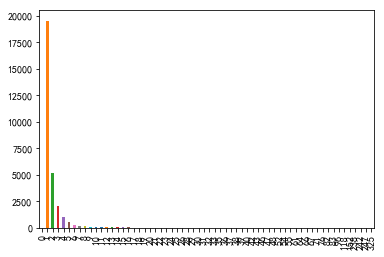

In [155]:
(df_p[df_p['fassured'] == 2].groupby('Insured\'s_ID')['Vehicle_identifier'].nunique()).value_counts().sort_index().plot.bar()

In [161]:
df_p[df_p['Insured\'s_ID'].map(df_p[df_p['fassured'] == 1].groupby('Insured\'s_ID')['Vehicle_identifier'].nunique() == 0) == True]
# .value_counts().sort_index().plot.bar()

,Policy_Number,Insured's_ID,Prior_Policy_Number,Cancellation,Vehicle_identifier,Vehicle_Make_and_Model1,Vehicle_Make_and_Model2,Manafactured_Year_and_Month,Engine_Displacement_(Cubic_Centimeter),Imported_or_Domestic_Car,Coding_of_Vehicle_Branding_&_Type,qpt,fpt,Main_Insurance_Coverage_Group,Insurance_Coverage,Insured_Amount1,Insured_Amount2,Insured_Amount3,Coverage_Deductible_if_applied,Premium,Replacement_cost_of_insured_vehicle,Distribution_Channel,Multiple_Products_with_TmNewa_(Yes_or_No?),lia_class,plia_acc,pdmg_acc,fassured,ibirth,fsex,fmarriage,aassured_zip,iply_area,dbirth,fequipment1,fequipment2,fequipment3,fequipment4,fequipment5,fequipment6,fequipment9,nequipment9
29760,7331b0f93b47fda6f0a7e44cf4229764aaeca2e5,N66a6545a7edd89cf2501d232c4a593efda8f3b59,NaN,Y,NaN,dda1b15cf567d2402a0d1249ee12e9e072bb3120,76f5b3ab6a5b6d3667ed43b8dd6334e0fc495b77,2015,1497,10,b9822096296d7ed90d194e32975c4f7072c15208,5.0,P,車損,03L,0,0,699000,0,99,69.9,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,-1,-0.38,0.0,1,11/1963,2,2,9741f79aca77af5b5793817bd36737360dcb0a29,0286dd552c9bea9a69ecb3759e7b94777635514b,11/1963,0,0,0,0,0,0,0,
29761,7331b0f93b47fda6f0a7e44cf4229764aaeca2e5,N66a6545a7edd89cf2501d232c4a593efda8f3b59,NaN,Y,NaN,dda1b15cf567d2402a0d1249ee12e9e072bb3120,76f5b3ab6a5b6d3667ed43b8dd6334e0fc495b77,2015,1497,10,b9822096296d7ed90d194e32975c4f7072c15208,5.0,P,車損,04M,0,0,699000,0,7049,69.9,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,-1,-0.38,0.0,1,11/1963,2,2,9741f79aca77af5b5793817bd36737360dcb0a29,0286dd552c9bea9a69ecb3759e7b94777635514b,11/1963,0,0,0,0,0,0,0,
29762,7331b0f93b47fda6f0a7e44cf4229764aaeca2e5,N66a6545a7edd89cf2501d232c4a593efda8f3b59,NaN,Y,NaN,dda1b15cf567d2402a0d1249ee12e9e072bb3120,76f5b3ab6a5b6d3667ed43b8dd6334e0fc495b77,2015,1497,10,b9822096296d7ed90d194e32975c4f7072c15208,5.0,P,車損,05E,0,0,699000,0,106,69.9,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,-1,-0.38,0.0,1,11/1963,2,2,9741f79aca77af5b5793817bd36737360dcb0a29,0286dd552c9bea9a69ecb3759e7b94777635514b,11/1963,0,0,0,0,0,0,0,
29763,7331b0f93b47fda6f0a7e44cf4229764aaeca2e5,N66a6545a7edd89cf2501d232c4a593efda8f3b59,NaN,Y,NaN,dda1b15cf567d2402a0d1249ee12e9e072bb3120,76f5b3ab6a5b6d3667ed43b8dd6334e0fc495b77,2015,1497,10,b9822096296d7ed90d194e32975c4f7072c15208,5.0,P,竊盜,05N,0,0,699000,10,2443,69.9,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,-1,-0.38,0.0,1,11/1963,2,2,9741f79aca77af5b5793817bd36737360dcb0a29,0286dd552c9bea9a69ecb3759e7b94777635514b,11/1963,0,0,0,0,0,0,0,
29764,7331b0f93b47fda6f0a7e44cf4229764aaeca2e5,N66a6545a7edd89cf2501d232c4a593efda8f3b59,NaN,Y,NaN,dda1b15cf567d2402a0d1249ee12e9e072bb3120,76f5b3ab6a5b6d3667ed43b8dd6334e0fc495b77,2015,1497,10,b9822096296d7ed90d194e32975c4f7072c15208,5.0,P,竊盜,09@,0,0,699000,0,366,69.9,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,-1,-0.38,0.0,1,11/1963,2,2,9741f79aca77af5b5793817bd36737360dcb0a29,0286dd552c9bea9a69ecb3759e7b94777635514b,11/1963,0,0,0,0,0,0,0,
29765,7331b0f93b47fda6f0a7e44cf4229764aaeca2e5,N66a6545a7edd89cf2501d232c4a593efda8f3b59,NaN,Y,NaN,dda1b15cf567d2402a0d1249ee12e9e072bb3120,76f5b3ab6a5b6d3667ed43b8dd6334e0fc495b77,2015,1497,10,b9822096296d7ed90d194e32975c4f7072c15208,5.0,P,車責,15F,0,0,10000000,100,1040,69.9,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,-1,-0.38,0.0,1,11/1963,2,2,9741f79aca77af5b5793817bd36737360dcb0a29,0286dd552c9bea9a69ecb3759e7b94777635514b,11/1963,0,0,0,0,0,0,0,
29766,7331b0f93b47fda6f0a7e44cf4229764aaeca2e5,N66a6545a7edd89cf2501d232c4a593efda8f3b59,NaN,Y,NaN,dda1b15cf567d2402a0d1249ee12e9e072bb3120,76f5b3ab6a5b6d3667ed43b8dd6334e0fc495b77,2015,1497,10,b9822096296d7ed90d194e32975c4f7072c15208,5.0,P,車責,16G,3000000,0,36000000,0,1351,69.9,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,-1,-0.38,0.0,1,11/1963,2,2,9741f79aca77af5b5793817bd36737360dcb0a29,0286dd552c9bea9a69ecb3759e7b94777635514b,11/1963,0,0,0,0,0,0,0,
29767,7331b0f93b47fda6f0a7e44cf4229764aaeca2e5,N66a6545a7edd89cf2501d232c4a593efda8f3b59,NaN,Y,NaN,dda1b15cf567d2402a0d1249ee12e9e072bb3120,76f5b3ab6a5b6d3667ed43b8dd6334e0